In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
base_name = 'ExtendedRange_Combined1Distribution'
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 44 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_44met_{base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra = np.load(f'Dataset44_{base_name}_ForManuscript_Spec.npy')
conc1 = np.load(f'Dataset44_{base_name}_ForManuscript_Conc.npy')

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [5]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal = torch.tensor(spectraVal).float().to(device)   # Confusing names, these spectra are the 5000 spectra generated like the training dataset
#ValSpectra = torch.tensor(ValSpectra).float().to(device)   # Confusing names, these spectra are the 10 representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#concVal = torch.tensor(concVal).float().to(device)
#ValConc = torch.tensor(ValConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 76, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 76, shuffle=True)

In [6]:
del X_train
del X_test
del y_train
del y_test
del spectra
del conc1
del datasets
del Test_datasets

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(23552, 44)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 1         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.0     # Dropout rate


In [8]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [9]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.00014656680844397094, weight_decay=0.01)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
            
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break



    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [10]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 9768.6342, Test Loss: 2274.4909
Epoch [2/1000], Train Loss: 8682.0276, Test Loss: 2122.7735
Epoch [3/1000], Train Loss: 8415.8031, Test Loss: 2051.5013
Epoch [4/1000], Train Loss: 7966.7923, Test Loss: 1858.7464
Epoch [5/1000], Train Loss: 6740.4731, Test Loss: 1430.0332
Epoch [6/1000], Train Loss: 4739.8960, Test Loss: 982.2537
Epoch [7/1000], Train Loss: 3420.4332, Test Loss: 737.1481
Epoch [8/1000], Train Loss: 2601.8719, Test Loss: 583.9640
Epoch [9/1000], Train Loss: 2069.4858, Test Loss: 474.4746
Epoch [10/1000], Train Loss: 1693.5616, Test Loss: 382.8749
Epoch [11/1000], Train Loss: 1448.0992, Test Loss: 351.3402
Epoch [12/1000], Train Loss: 1239.3193, Test Loss: 286.2241
Epoch [13/1000], Train Loss: 1078.7155, Test Loss: 264.2786
Epoch [14/1000], Train Loss: 962.5003, Test Loss: 238.2417
Epoch [15/1000], Train Loss: 858.4195, Test Loss: 210.8160
Epoch [16/1000], Train Loss: 784.7083, Test Loss: 188.58

Epoch [140/1000], Train Loss: 223.8037, Test Loss: 61.1787
Epoch [141/1000], Train Loss: 229.0449, Test Loss: 65.5962
Epoch [142/1000], Train Loss: 221.2240, Test Loss: 57.2717
Epoch [143/1000], Train Loss: 223.3654, Test Loss: 58.1264
Epoch [144/1000], Train Loss: 221.8895, Test Loss: 61.3606
Epoch [145/1000], Train Loss: 220.3305, Test Loss: 61.6050
Epoch [146/1000], Train Loss: 225.9637, Test Loss: 59.7963
Epoch [147/1000], Train Loss: 218.1635, Test Loss: 67.3163
Epoch [148/1000], Train Loss: 220.0414, Test Loss: 59.6796
Epoch [149/1000], Train Loss: 221.0134, Test Loss: 59.1843
Epoch [150/1000], Train Loss: 218.4484, Test Loss: 56.3634
Epoch [151/1000], Train Loss: 219.7992, Test Loss: 60.4774
Epoch [152/1000], Train Loss: 220.0223, Test Loss: 58.3754
Epoch [153/1000], Train Loss: 218.0058, Test Loss: 60.5449
Epoch [154/1000], Train Loss: 218.9510, Test Loss: 56.7896
Epoch [155/1000], Train Loss: 214.9486, Test Loss: 56.4843
Epoch [156/1000], Train Loss: 216.9013, Test Loss: 61.72

Epoch [279/1000], Train Loss: 175.1619, Test Loss: 46.2586
Epoch [280/1000], Train Loss: 170.2215, Test Loss: 46.4901
Epoch [281/1000], Train Loss: 171.5726, Test Loss: 47.7603
Epoch [282/1000], Train Loss: 168.3739, Test Loss: 45.8794
Epoch [283/1000], Train Loss: 167.3765, Test Loss: 44.9740
Epoch [284/1000], Train Loss: 171.1131, Test Loss: 48.4724
Epoch [285/1000], Train Loss: 170.8861, Test Loss: 48.5990
Epoch [286/1000], Train Loss: 168.0157, Test Loss: 45.4866
Epoch [287/1000], Train Loss: 166.0270, Test Loss: 47.1684
Epoch [288/1000], Train Loss: 167.1565, Test Loss: 46.8365
Epoch [289/1000], Train Loss: 169.9612, Test Loss: 46.1928
Epoch [290/1000], Train Loss: 167.4380, Test Loss: 49.6653
Epoch [291/1000], Train Loss: 168.4211, Test Loss: 45.8201
Epoch [292/1000], Train Loss: 168.2107, Test Loss: 44.0161
Epoch [293/1000], Train Loss: 164.8375, Test Loss: 45.7780
Epoch [294/1000], Train Loss: 168.7344, Test Loss: 43.6293
Epoch [295/1000], Train Loss: 166.0547, Test Loss: 43.65

Epoch [418/1000], Train Loss: 149.5263, Test Loss: 39.4605
Epoch [419/1000], Train Loss: 147.5406, Test Loss: 43.2792
Epoch [420/1000], Train Loss: 153.6185, Test Loss: 44.5176
Epoch [421/1000], Train Loss: 146.7417, Test Loss: 39.2772
Epoch [422/1000], Train Loss: 149.1666, Test Loss: 43.0611
Epoch [423/1000], Train Loss: 152.7685, Test Loss: 40.6534
Epoch [424/1000], Train Loss: 150.6290, Test Loss: 41.2615
Epoch [425/1000], Train Loss: 148.0209, Test Loss: 37.5407
Epoch [426/1000], Train Loss: 147.1204, Test Loss: 41.9761
Epoch [427/1000], Train Loss: 148.7544, Test Loss: 43.1292
Epoch [428/1000], Train Loss: 148.3069, Test Loss: 40.4445
Epoch [429/1000], Train Loss: 147.2020, Test Loss: 40.8566
Epoch [430/1000], Train Loss: 151.4013, Test Loss: 42.4447
Epoch [431/1000], Train Loss: 148.4108, Test Loss: 43.3604
Epoch [432/1000], Train Loss: 145.8816, Test Loss: 41.2825
Epoch [433/1000], Train Loss: 145.4074, Test Loss: 40.2328
Epoch [434/1000], Train Loss: 145.0930, Test Loss: 44.43

Epoch [557/1000], Train Loss: 137.1380, Test Loss: 36.1186
Epoch [558/1000], Train Loss: 136.3719, Test Loss: 37.9457
Epoch [559/1000], Train Loss: 140.4029, Test Loss: 37.1455
Epoch [560/1000], Train Loss: 139.1716, Test Loss: 36.2384
Epoch [561/1000], Train Loss: 137.2481, Test Loss: 35.9479
Epoch [562/1000], Train Loss: 138.0822, Test Loss: 35.5285
Epoch [563/1000], Train Loss: 140.3412, Test Loss: 37.1566
Epoch [564/1000], Train Loss: 137.2031, Test Loss: 36.8542
Epoch [565/1000], Train Loss: 134.8306, Test Loss: 37.6217
Epoch [566/1000], Train Loss: 140.3629, Test Loss: 39.5834
Epoch [567/1000], Train Loss: 138.6629, Test Loss: 39.1745
Epoch [568/1000], Train Loss: 136.0834, Test Loss: 39.4351
Epoch [569/1000], Train Loss: 135.0898, Test Loss: 37.5754
Epoch [570/1000], Train Loss: 134.9988, Test Loss: 36.6079
Epoch [571/1000], Train Loss: 135.7800, Test Loss: 37.5285
Epoch [572/1000], Train Loss: 135.3782, Test Loss: 36.5832
Epoch [573/1000], Train Loss: 136.2086, Test Loss: 37.64

In [11]:
np.array(test_losses).min()

35.043443808332086

In [12]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset44_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_44met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_44met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_44met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_44met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_44met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_44met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_44met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_44met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_44met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_44met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_44met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [13]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=23552, out_features=44, bias=True)
)

In [14]:
Prediction = model_aq(spectraVal[0].unsqueeze(0))

Prediction

tensor([[22.3186, 10.0557, 16.8672,  6.4503, 16.3615,  4.4957, 13.0599,  2.0597,
          6.9443,  3.1679,  5.2439,  8.2109, 11.2430, 12.2410, 23.6758, 16.9509,
          5.1908, 13.5993,  8.5342, 22.8299, 22.8827,  9.8697, 10.3711, 23.3786,
         17.0036,  7.1682, 18.2540, 10.5751, 13.2299, 19.9929, 17.4601,  6.5707,
          8.6804, 11.9150,  9.8287,  2.7491, 15.6290,  5.0556, 14.2633, 21.2165,
         11.5085, 19.1922,  5.0861,  8.3342]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
Prediction.detach().cpu().numpy()[0]

array([22.318644 , 10.055749 , 16.867224 ,  6.450286 , 16.361458 ,
        4.495678 , 13.059892 ,  2.0597162,  6.944264 ,  3.1678512,
        5.243852 ,  8.2109165, 11.242998 , 12.241046 , 23.675842 ,
       16.950869 ,  5.1907697, 13.599286 ,  8.534188 , 22.829926 ,
       22.88275  ,  9.869687 , 10.371068 , 23.378635 , 17.003555 ,
        7.168171 , 18.25403  , 10.575075 , 13.229913 , 19.99288  ,
       17.460054 ,  6.57069  ,  8.680365 , 11.914987 ,  9.828661 ,
        2.7490828, 15.628984 ,  5.055611 , 14.263347 , 21.216516 ,
       11.508531 , 19.192171 ,  5.086134 ,  8.334219 ], dtype=float32)

In [16]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  53.483715192110765


In [17]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
86.29  - Concentrations: 0.004999999888241291
18.75  - Concentrations: 0.02500000037252903
4.77  - Concentrations: 0.10000000149011612
1.88  - Concentrations: 0.25
1.02  - Concentrations: 0.5
0.61  - Concentrations: 1.0
0.5  - Concentrations: 2.5
0.4  - Concentrations: 10.0
0.66  - Concentrations: 20.0


In [18]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  1.3787415
--------------------
0.75  - Min Value: 0.6783  - Mean Value: 9.2
6.2  - Min Value: 0.0096  - Mean Value: 10.3
1.04  - Min Value: 0.147  - Mean Value: 10.5
0.88  - Min Value: 0.5572  - Mean Value: 8.5
0.7  - Min Value: 1.3567  - Mean Value: 10.6
0.71  - Min Value: 0.6332  - Mean Value: 10.9
0.9  - Min Value: 0.7017  - Mean Value: 11.0
1.4  - Min Value: 0.3674  - Mean Value: 8.9
0.62  - Min Value: 0.8387  - Mean Value: 9.8
0.6  - Min Value: 1.0913  - Mean Value: 11.1


In [19]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  5.868741
--------------------
4.52  - Min Value: 0.0111  - Mean Value: 0.1
6.13  - Min Value: 0.0103  - Mean Value: 0.1
6.41  - Min Value: 0.0153  - Mean Value: 0.1
7.03  - Min Value: 0.0117  - Mean Value: 0.1
5.51  - Min Value: 0.0089  - Mean Value: 0.1
6.27  - Min Value: 0.0075  - Mean Value: 0.1
6.58  - Min Value: 0.0117  - Mean Value: 0.1
5.64  - Min Value: 0.0052  - Mean Value: 0.1
6.11  - Min Value: 0.008  - Mean Value: 0.1
4.48  - Min Value: 0.0134  - Mean Value: 0.1


In [20]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  9.376745
--------------------
15.95  - Min Value: 0.008  - Mean Value: 0.8
17.11  - Min Value: 0.009  - Mean Value: 0.9
12.77  - Min Value: 0.0138  - Mean Value: 1.5
4.52  - Min Value: 0.0107  - Mean Value: 0.7
6.74  - Min Value: 0.0191  - Mean Value: 0.7
8.85  - Min Value: 0.0186  - Mean Value: 0.8
6.34  - Min Value: 0.0175  - Mean Value: 0.8
7.06  - Min Value: 0.0238  - Mean Value: 1.3
3.68  - Min Value: 0.0168  - Mean Value: 0.7
10.75  - Min Value: 0.0171  - Mean Value: 0.9


In [21]:
APEs[0]

[tensor(0.6473),
 tensor(4.7116),
 tensor(0.7293),
 tensor(10.9185),
 tensor(73.1784),
 tensor(0.1686),
 tensor(93.9324),
 tensor(5.0490),
 tensor(27.7407),
 tensor(1.3097),
 tensor(0.0509),
 tensor(79.9241),
 tensor(0.5943),
 tensor(0.2915),
 tensor(43.4490),
 tensor(0.6091),
 tensor(2.4511),
 tensor(48.1740),
 tensor(1.7674),
 tensor(5.2987),
 tensor(84.0777),
 tensor(0.6527),
 tensor(20.8640),
 tensor(30.6461),
 tensor(2.3432),
 tensor(1.6327),
 tensor(3.9719),
 tensor(1.8190),
 tensor(0.3542),
 tensor(42.3722),
 tensor(0.2650),
 tensor(4.4001),
 tensor(3.0576),
 tensor(2.3614),
 tensor(16.9967),
 tensor(34.2504),
 tensor(7.6715),
 tensor(3.8089),
 tensor(5.3823),
 tensor(14.5623),
 tensor(5.8178),
 tensor(0.3832),
 tensor(3.5319),
 tensor(9.4580)]

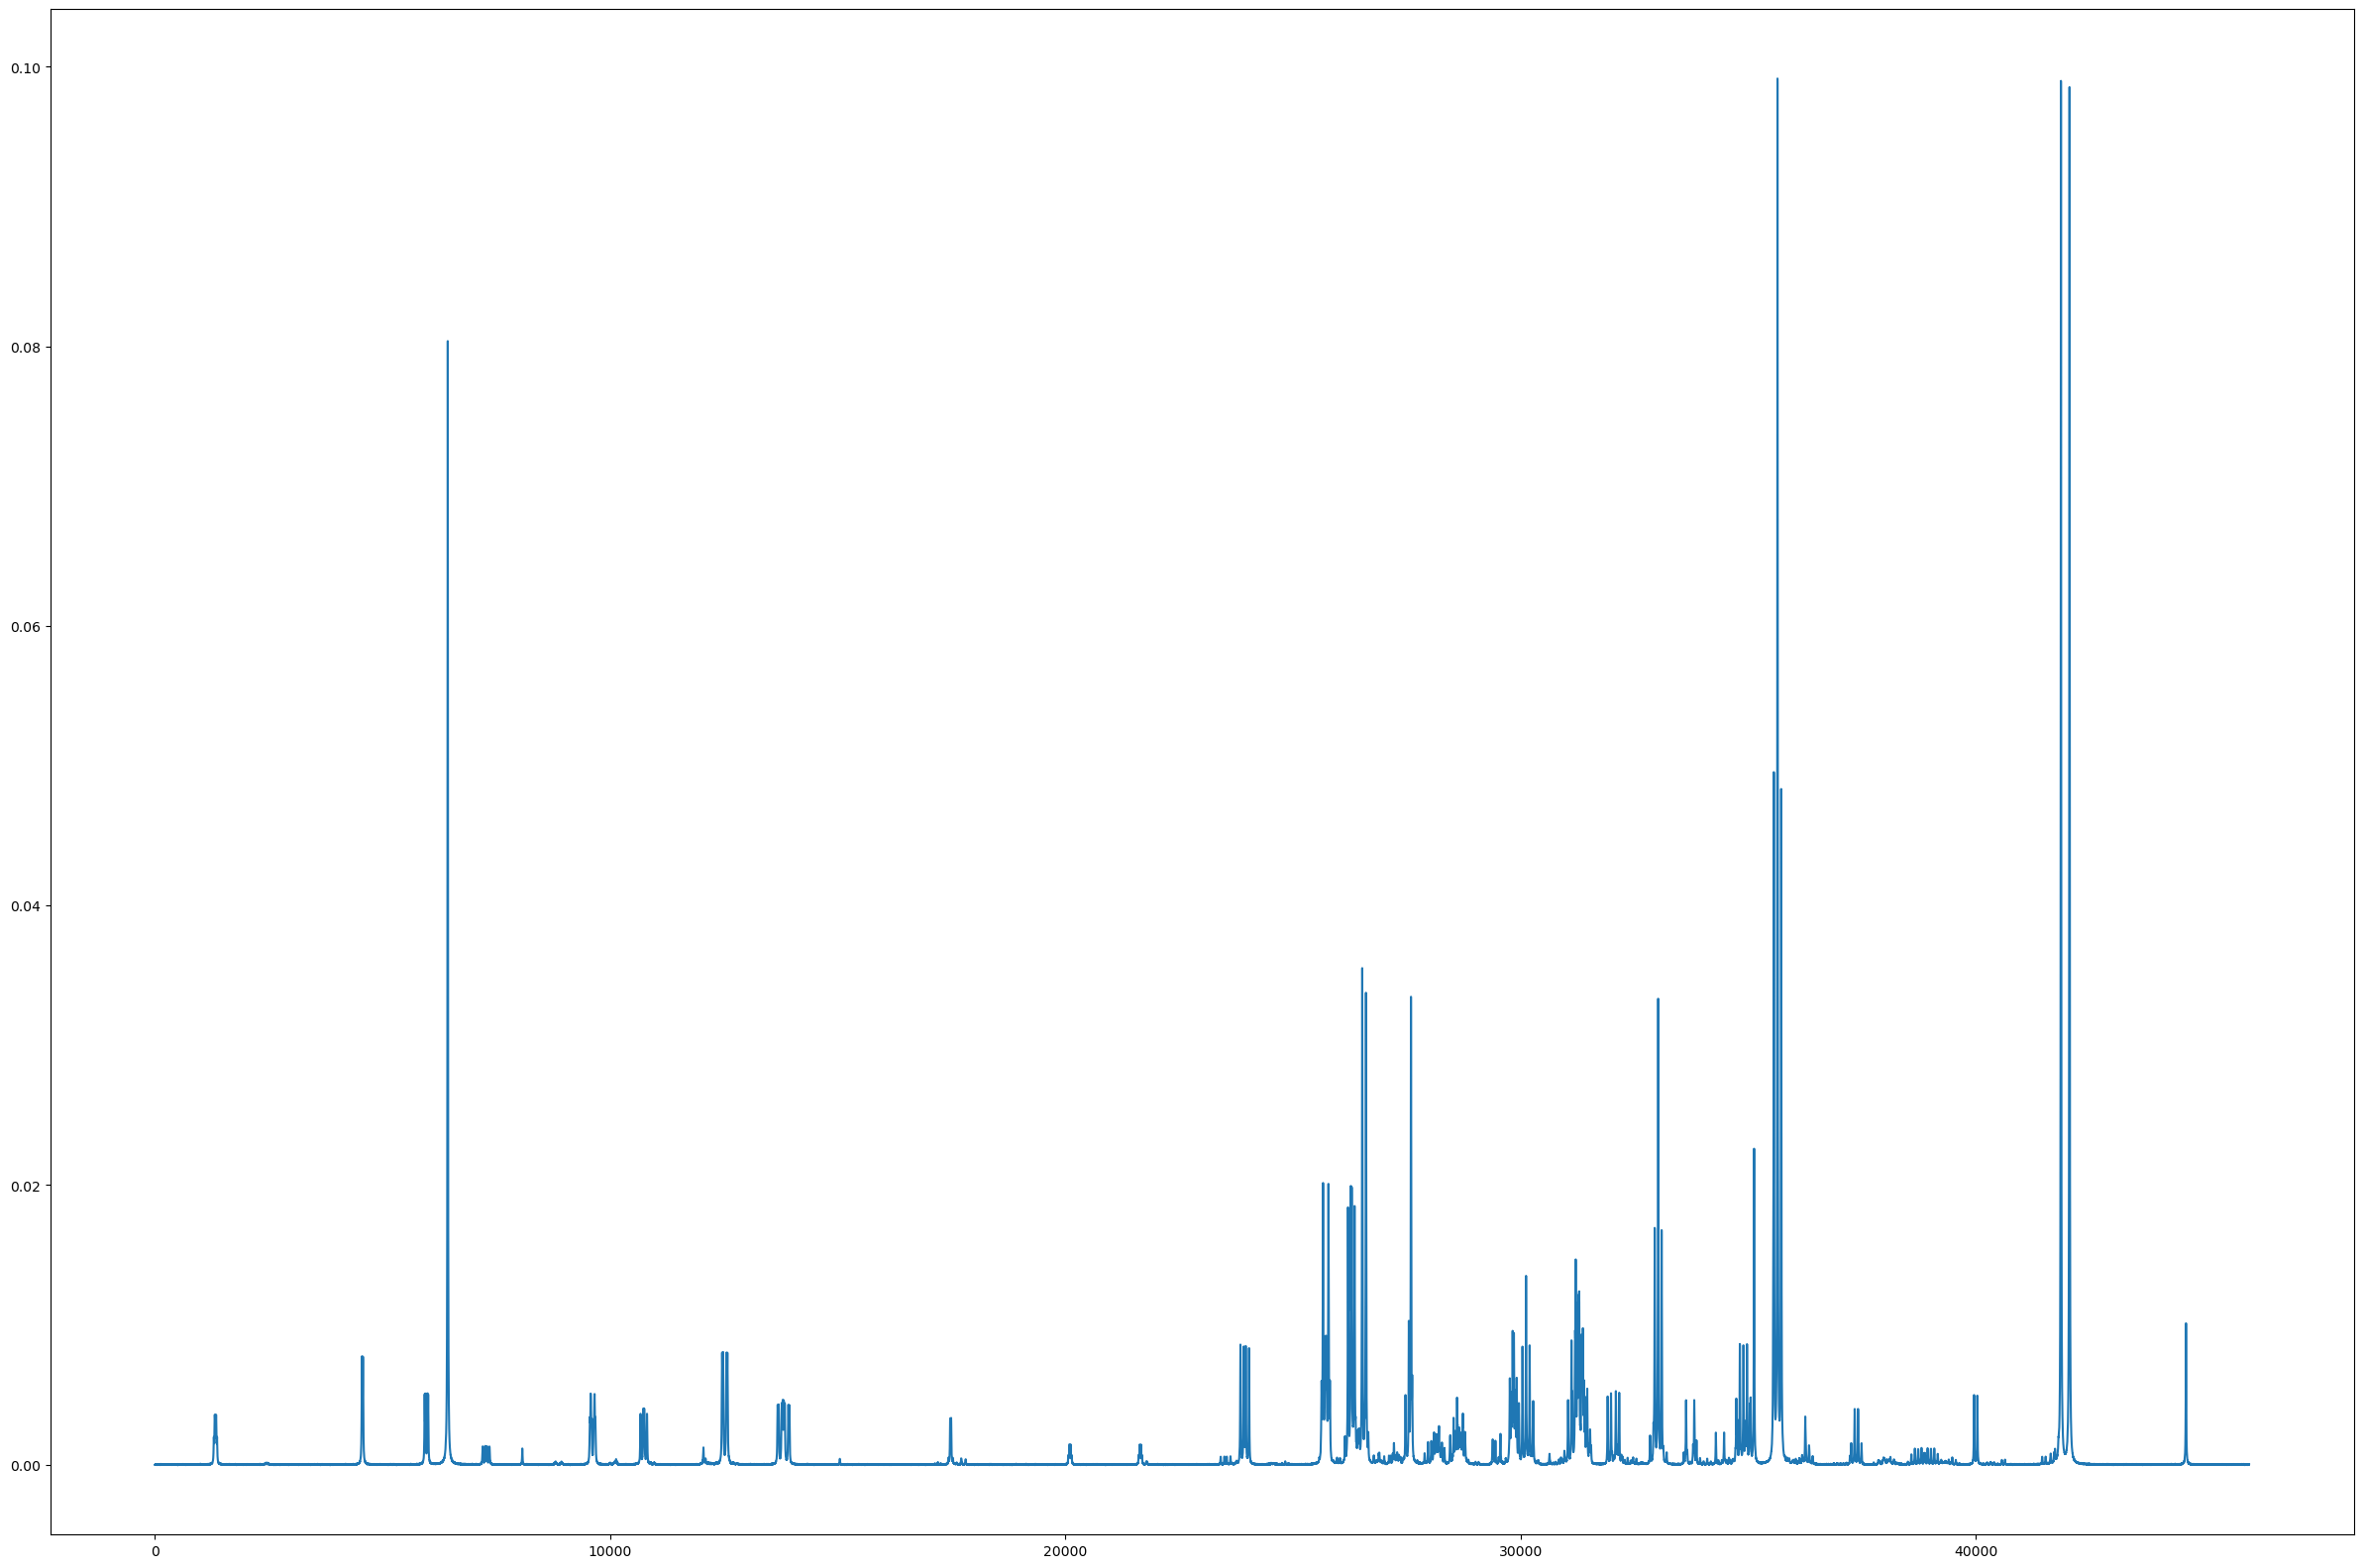

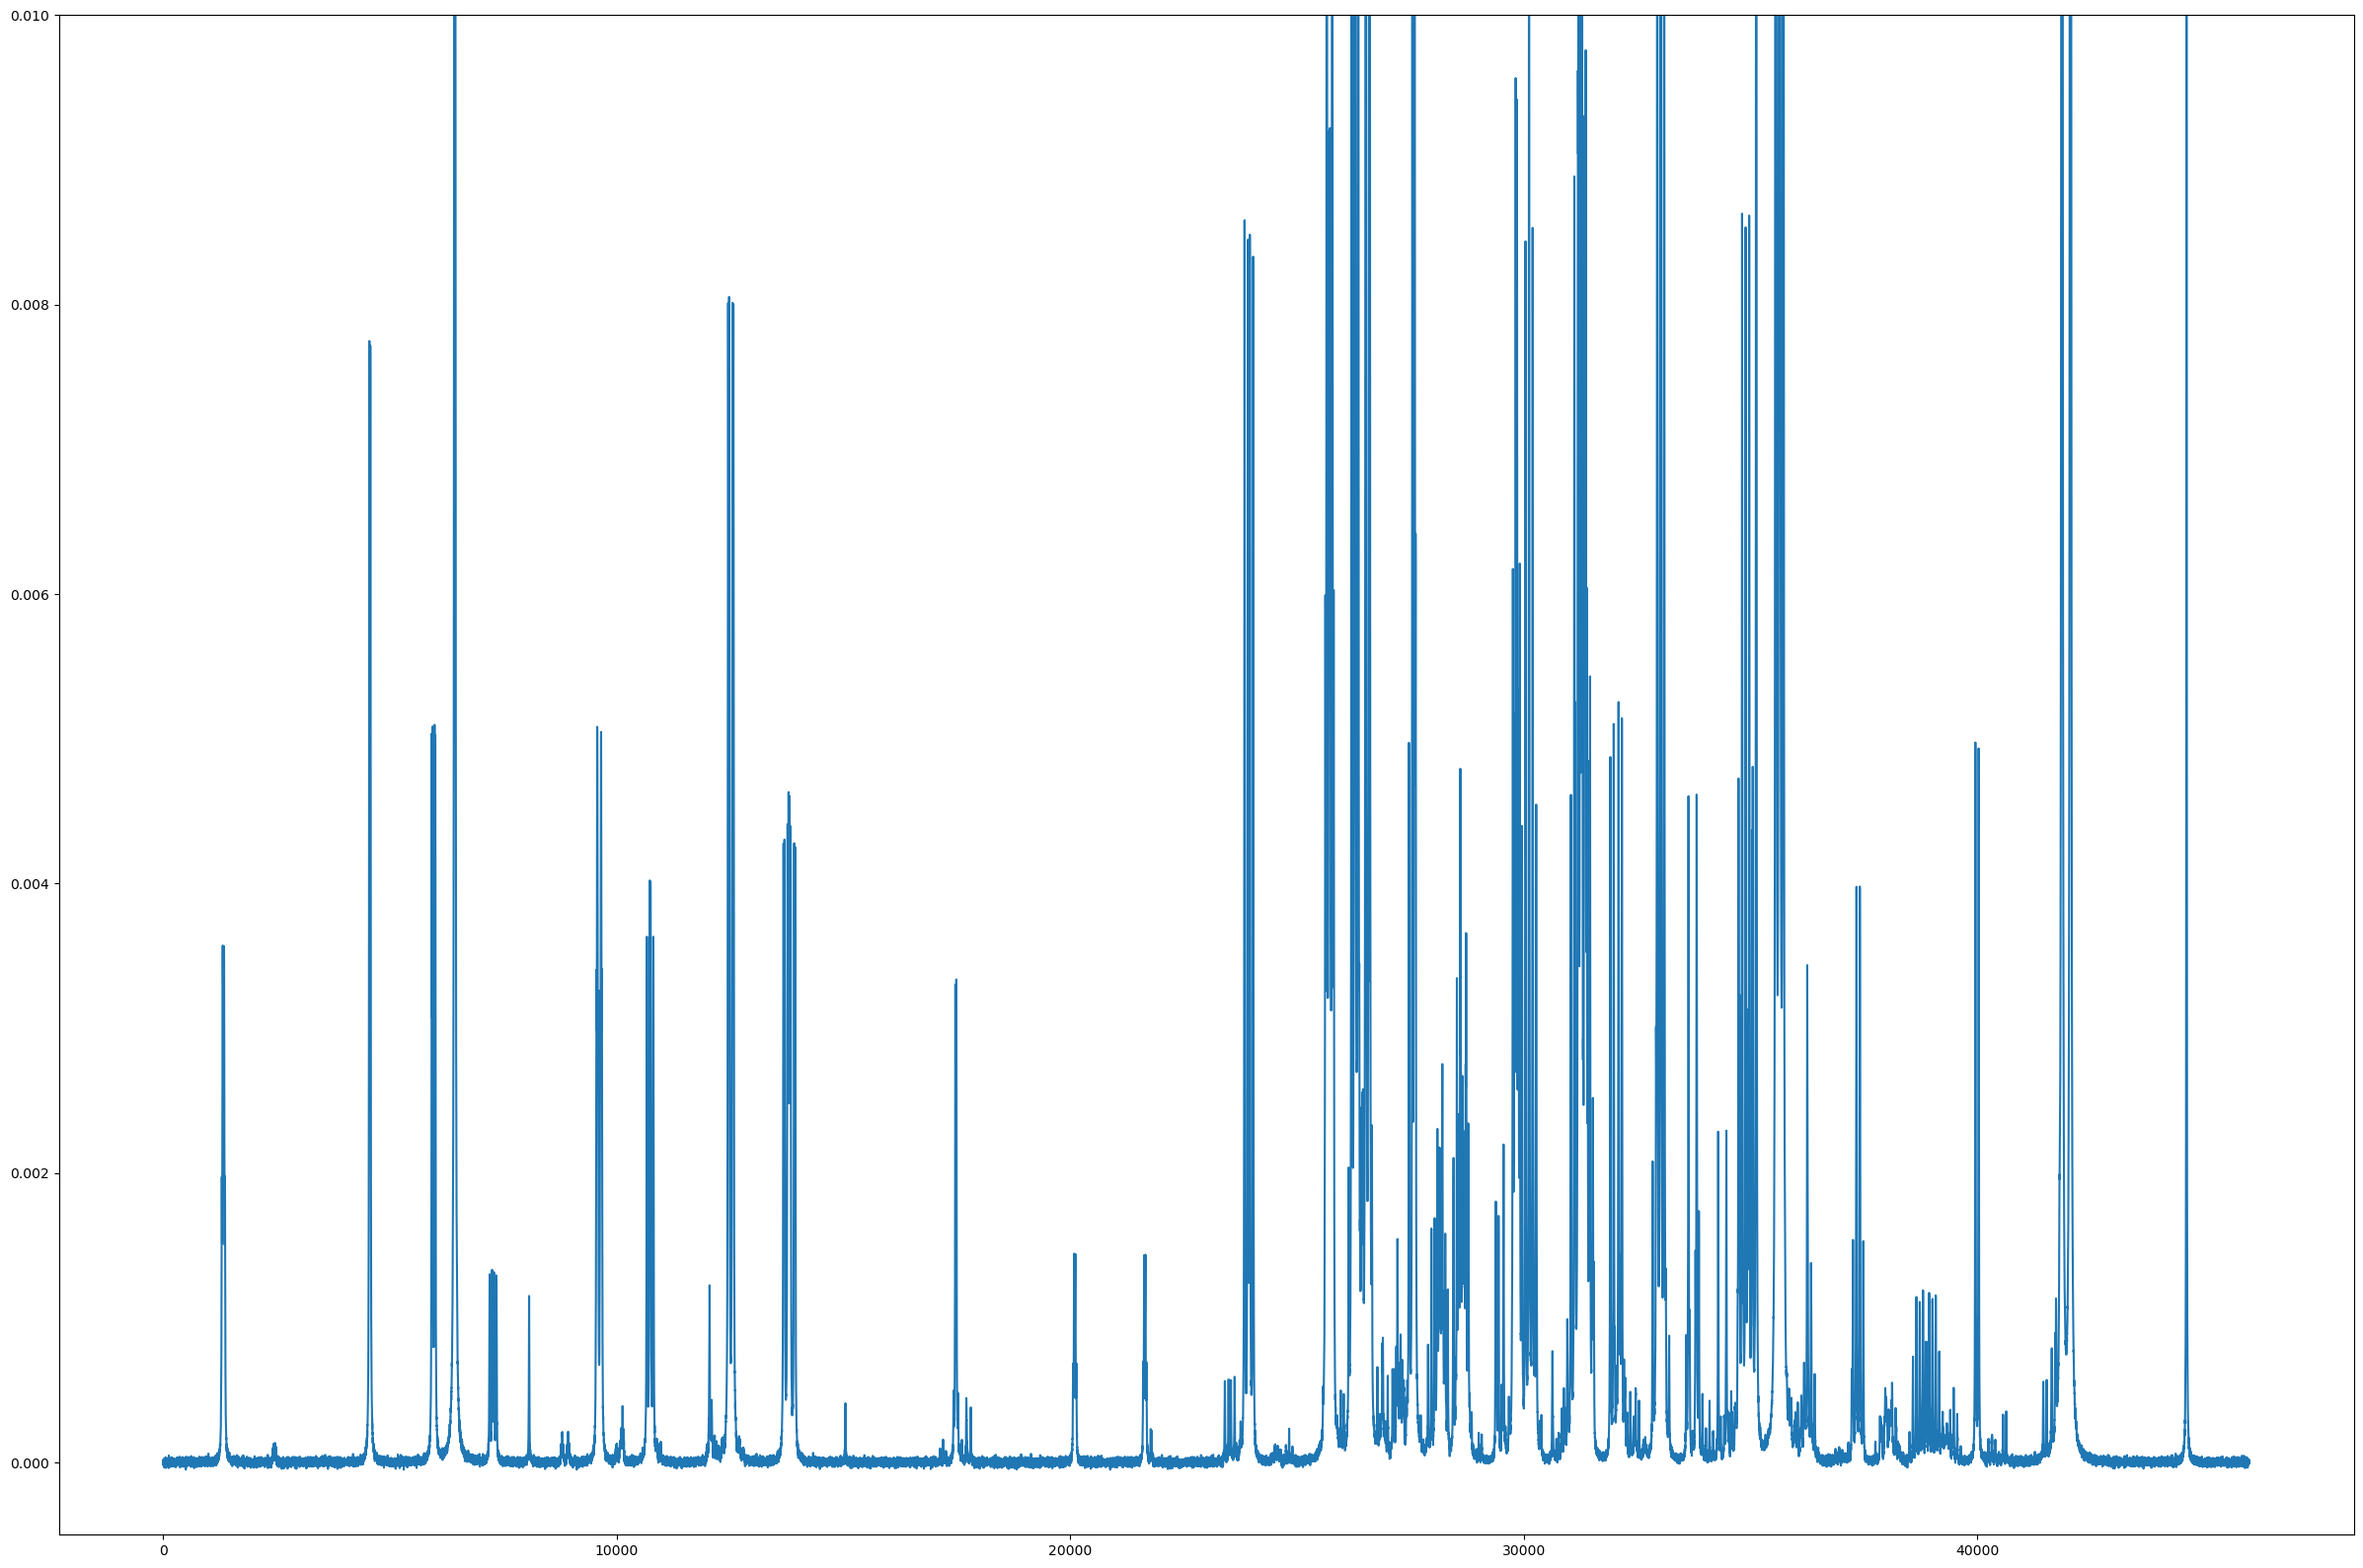

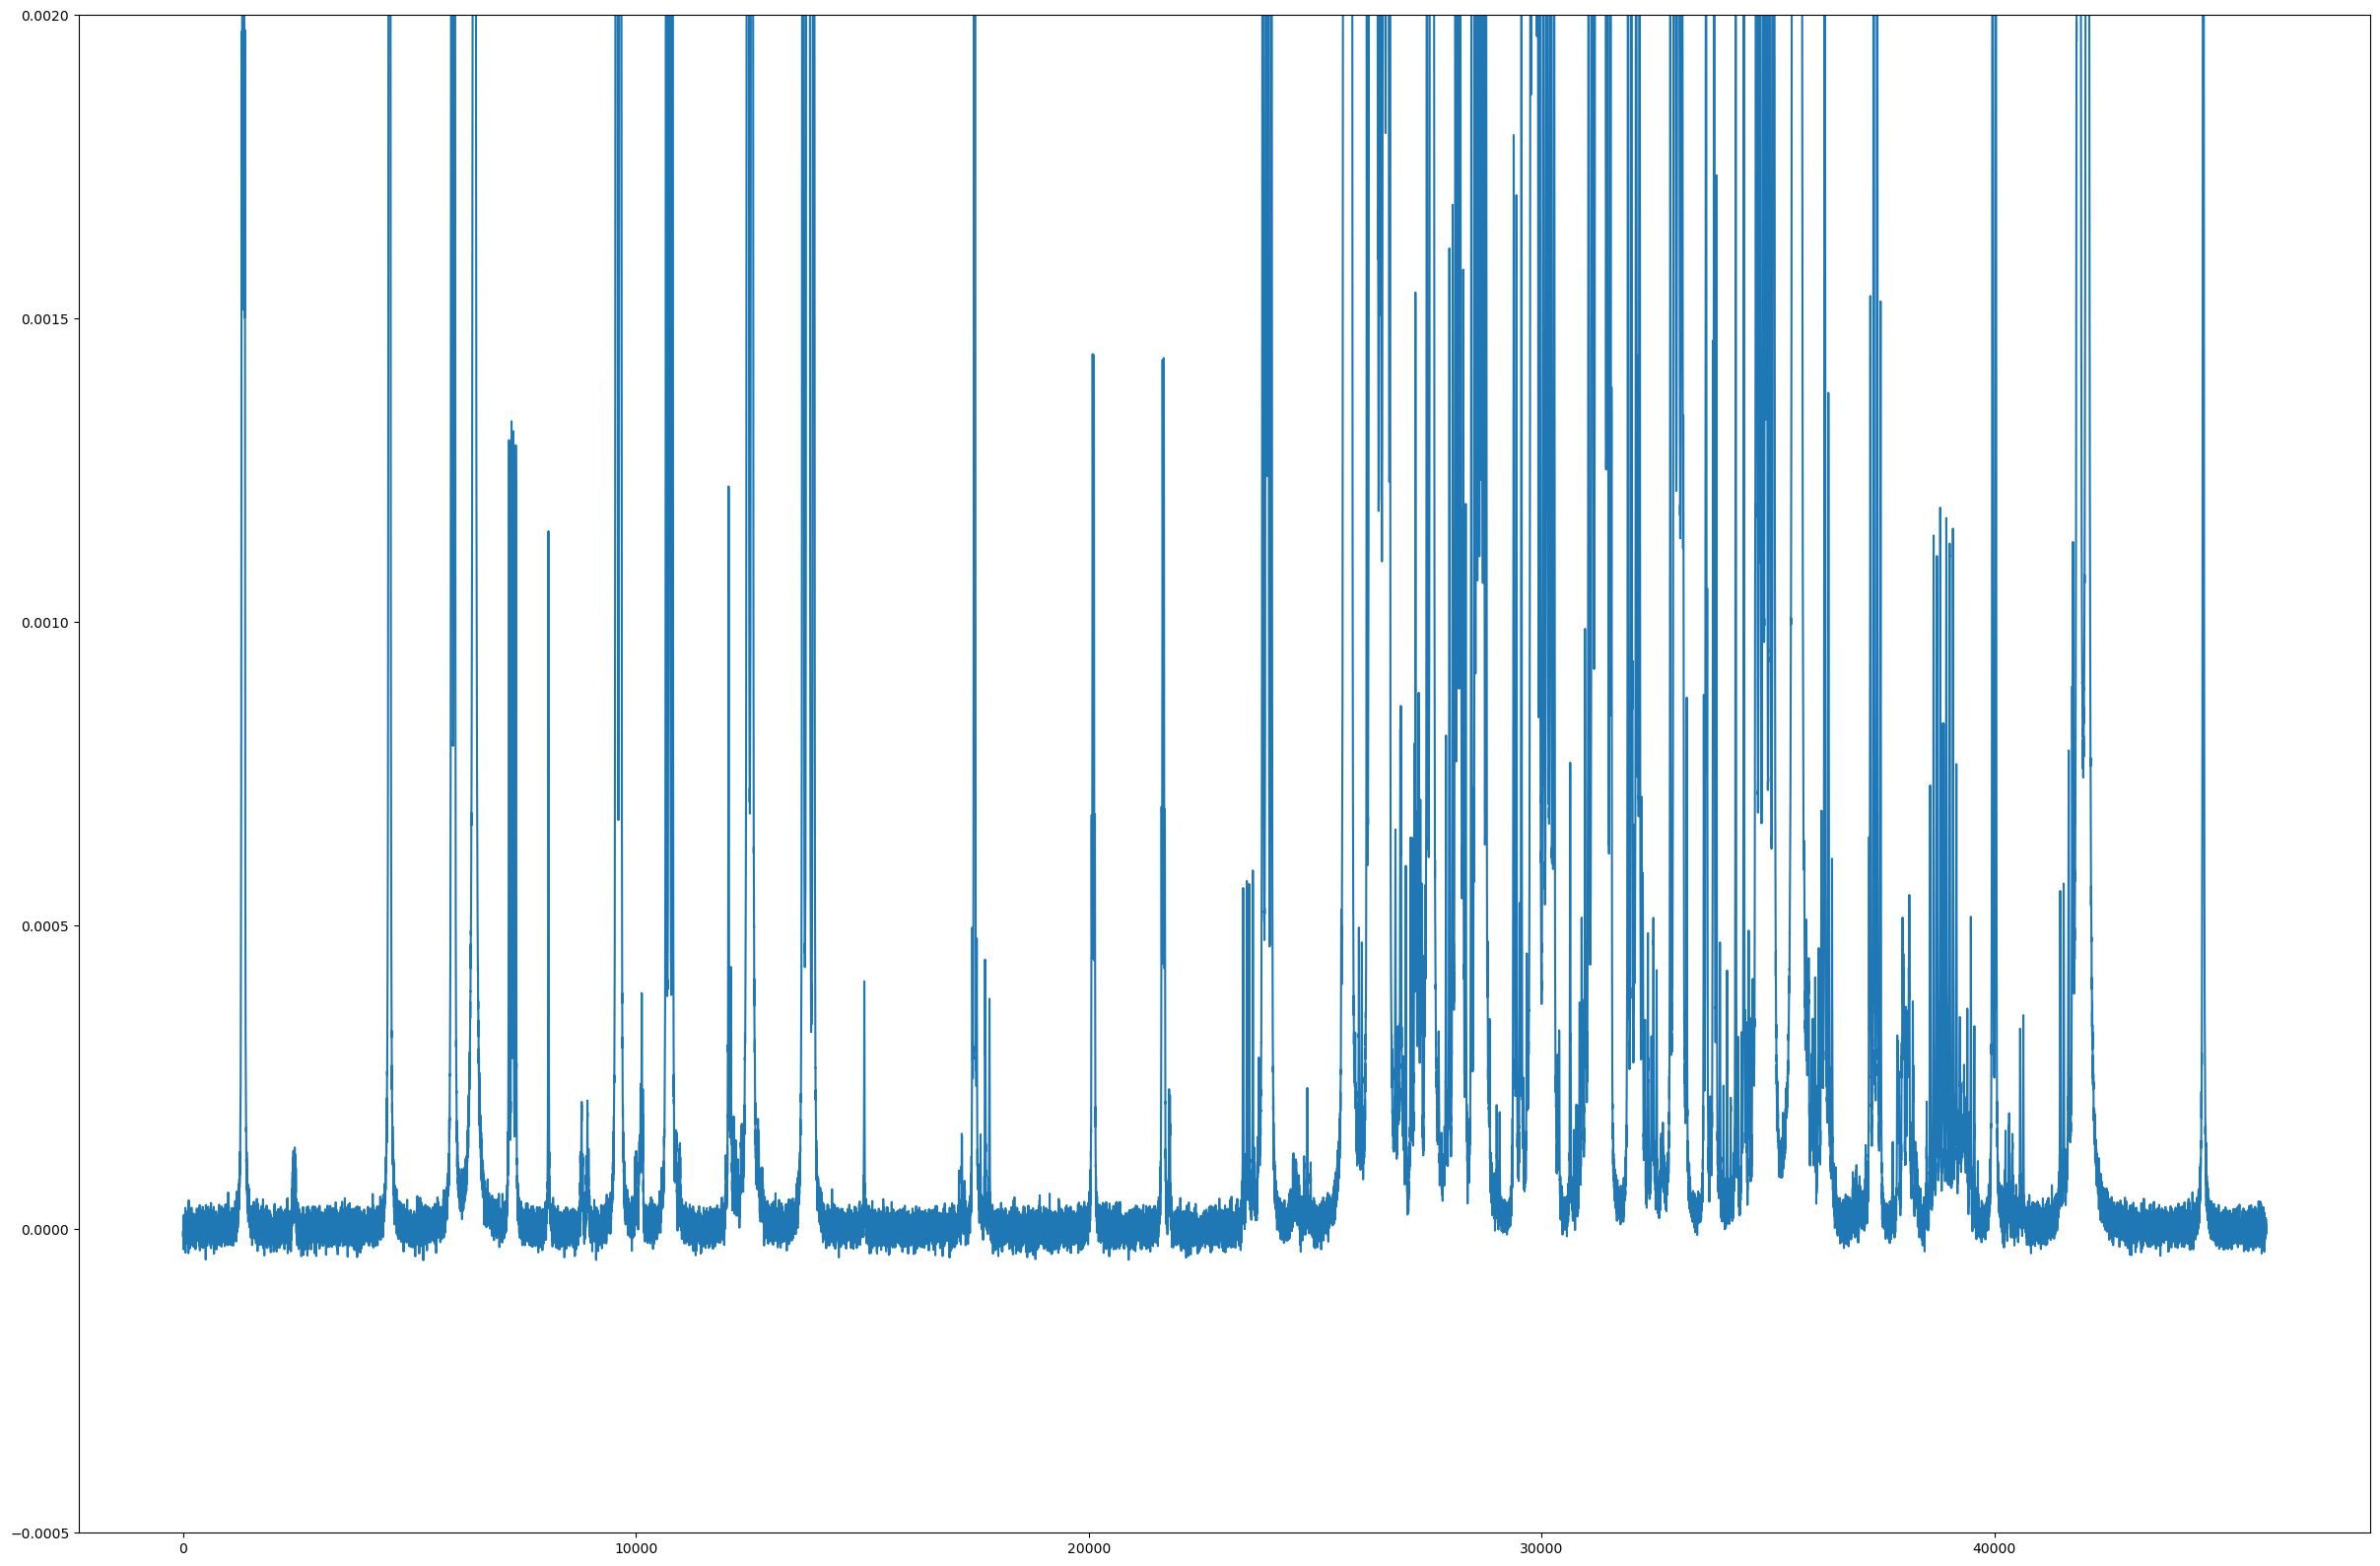

In [22]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [23]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  14.113538
--------------------
11.56  - Min Value: 0.013  - Mean Value: 0.6
10.92  - Min Value: 0.0115  - Mean Value: 0.4
8.25  - Min Value: 0.0115  - Mean Value: 0.4
7.67  - Min Value: 0.0115  - Mean Value: 0.6
9.09  - Min Value: 0.0115  - Mean Value: 1.0
24.09  - Min Value: 0.0115  - Mean Value: 1.1
32.71  - Min Value: 0.0115  - Mean Value: 0.8
9.88  - Min Value: 0.0115  - Mean Value: 0.5
8.07  - Min Value: 0.0115  - Mean Value: 0.5
18.9  - Min Value: 0.0115  - Mean Value: 1.1


In [24]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  67.852066
--------------------
97.86  - Min Value: 0.0062  - Mean Value: 2.1
62.36  - Min Value: 0.006  - Mean Value: 3.7
57.48  - Min Value: 0.0066  - Mean Value: 4.3
62.0  - Min Value: 0.0094  - Mean Value: 4.3
58.15  - Min Value: 0.0068  - Mean Value: 4.9
77.75  - Min Value: 0.005  - Mean Value: 3.8
67.23  - Min Value: 0.0101  - Mean Value: 3.2
41.65  - Min Value: 0.0062  - Mean Value: 3.2
83.79  - Min Value: 0.0053  - Mean Value: 5.3
70.25  - Min Value: 0.0054  - Mean Value: 2.5


In [25]:
ConcConc[5]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
       device='cuda:0')

In [26]:
model_aq(ConcSpec[5])

tensor([[0.5059, 0.5013, 0.5056, 0.5017, 0.4947, 0.5035, 0.5056, 0.5155, 0.5025,
         0.4993, 0.4975, 0.4901, 0.5016, 0.5010, 0.4921, 0.5042, 0.5046, 0.5080,
         0.5009, 0.4981, 0.5029, 0.5099, 0.4933, 0.5002, 0.5137, 0.5148, 0.4963,
         0.5118, 0.5016, 0.5042, 0.5050, 0.5047, 0.5047, 0.5071, 0.5018, 0.5069,
         0.5067, 0.4969, 0.4988, 0.4961, 0.4968, 0.5059, 0.5052, 0.4948]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [27]:
model_aq(SNR_Spec[1])

tensor([[0.4349, 0.4342, 0.4339, 0.4277, 0.4257, 0.4305, 0.4350, 0.4421, 0.4319,
         0.4287, 0.4273, 0.4194, 0.4325, 0.4281, 0.4323, 0.4337, 0.4361, 0.4386,
         0.4318, 0.4280, 0.4315, 0.4423, 0.4218, 0.4310, 0.4405, 0.4452, 0.4239,
         0.4427, 0.4325, 0.4347, 0.4343, 0.4328, 0.4397, 0.4360, 0.4307, 0.4346,
         0.4392, 0.4334, 0.4233, 0.4265, 0.4232, 0.4350, 0.4350, 0.4230]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  1.4665932912403135
--------------------
1.17
1.23
1.22
1.26
1.48
1.34
1.68
1.53
1.84
1.91


In [29]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  14.120424591461653
--------------------
1.28
1.38
1.27
5.18
17.35
17.55
18.18
22.08
27.17
29.76


In [30]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(44):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  46.60217752077678
--------------------
3.5
13.31
23.68
33.49
43.61
53.0
61.55
69.83
78.15
85.9


In [31]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4793, 0.6186, 0.3929, 0.6631, 0.4920, 0.4989, 0.5228, 0.6732, 0.7363,
        0.4051, 0.4139, 0.7098, 0.5850, 0.9765, 0.3426, 0.7169, 0.6732, 0.4850,
        0.5068, 0.3904, 0.5263, 0.9478, 0.3209, 0.5608, 0.6192, 0.5028, 0.6366,
        0.7090, 0.5113, 0.4664, 0.4373, 0.8867, 0.4627, 0.4249, 0.4266, 0.5480,
        0.5125, 0.4798, 0.7068, 0.3953, 0.3929, 0.5229, 0.6062, 0.4128],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.3815, 0.5447, 0.0852, 0.5929, 0.3854, 0.3965, 0.4179, 0.1561, 0.4225,
        0.5556, 0.3948, 0.4778, 0.8533, 0.4118, 0.7978, 0.0822, 0.8545, 0.5605,
        0.5052, 0.3293, 0.2665, 0.4239, 0.5271, 0.5560, 0.3489, 0.4684, 0.1683,
        0.0000, 0.5364, 0.3845, 0.3939, 0.4176, 0.3501, 0.4554, 0.5387, 0.4507,
        0.6813, 0.7906, 0.5498, 0.3363, 0.4380, 0.7932, 0.2147, 0.1366],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s a